# Análise temporal COVID-19 Brasil 

![Alt](https://www.pfizer.com.br/sites/default/files/inline-images/covid-19_0.jpg)

# Escopo do projeto

* __1-Introdução__
* __2-Importação dos pacotes__
* __3-Funções__
* __4-Limpeza dos dados brutos__
* __5-Leitura dos dados limpos__
* __6-Hipóteses__
* __7-Visualização dos dados__
* __8-Modelo do Prophet__
* __9-Conclusões__

# 1 - Introdução

A pandemia causada pelo novo coronavírus (SARS-CoV-2) está sendo responsável por diversos desafios e adversidades dia após dia enfrentados pela área da saúde no mundo. No Brasil, esse vírus, levou o país a uma crise sanitária por conta de sua rápida trasmissão por todo o país, afetando a vida de milhões de pessoas. Dentre essas pessoas estão aquelas responsáveis por fornecer os cuidados e os tratamentos responsáveis por salvar vidas, e, como o Brasil é o quinto maior país do mundo e, segundo estimativas da ONU, é a sexta maior população mundial, o controle de um vírus com essas características se torna muito mais complicado.

Pensando nisso, a análise teve como objetivo encontrar padrões nas notificações dos casos e óbitos por COVID-19, tentando entender se existe alguma forma de prever os dias onde a demanda de profissionais de saúde e de recursos precisa ser maior.

### __Séries Temporais__

Uma série temporal é uma observação de uma variável ao longo do tempo, ao se analisar uma série temporal devemos procurar se existe alguma dependência da variável e do período temporal e tentar achar os possíveis padrões.Muitas vezes, se encontrados esses padrões, podemos descrever uma série temporal através de funções matemáticas que podem ser úteis nas tomadas de decisões. 

No contexto da COVID-19, se analisarmos os números de casos e óbitos em relação ao dia de notificação podemos considerar esses dados constituindo uma série temporal e, a partir disso, usar técnicas apropriadas a esse tipo de dados para tentar descrever seu comportamento ao decorrer do tempo.

#### Mas como isso pode ser útil?

Entender se existe um padrão dentro da notificação de casos pode ajudar o planejamento de Hospitais e dos órgãos de sáude para perceber uma eventual demanda maior em determinadas épocas e com isso tentar melhorar a logística de equipamentos, leitos e de profissionais.

### __Sazonalidade__

A sazonalidade é um fator crucial na hora de analisar séries temporais, ela nos ajuda a entender os padrões, podendo assumir diferentes comportamnetos, por exemplo:

* Sazonalidade semanal : os dados variam de acordo com o dia da semana
* Sazonalidade mensal : os dados variam de acordo com o dia do mês
* Sazonalidade anual : os dados variam de acordo com a época do ano

Além disso existem diversos outros fatores temporais que podem influenciar os dados, como por exemplo feriados.

# 2 - Importação dos pacotes

In [27]:
import pandas as pd
import matplotlib as mlt
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import numpy as np
from plot import plot_time_series, million_formatter,thousand_formatter, percent_formatter, apresentacao
from model import Modelo_prophet_semanal
import logging
logging.getLogger('fbprophet').setLevel(logging.WARNING)
import warnings
warnings.filterwarnings('ignore')

In [28]:
#Setando parâmetros do matplotlib
mlt.rcParams['font.size'] = 18
mlt.rcParams['figure.figsize'] = (16,8)

# 3 - Funções

Aqui estão as funções auxiliares utilizadas no projeto:

In [29]:
help(Modelo_prophet_semanal)

Help on class Modelo_prophet_semanal in module model:

class Modelo_prophet_semanal(builtins.object)
 |  Modelo_prophet_semanal(dados: pandas.core.frame.DataFrame, teste_periodo: int = 0, regressors: list = [], **kwargs_model)
 |  
 |  Parâmetros Construtor:
 |  ---------------------
 |  dados : DataFrame com os dados de treino e teste com as colunas de data('ds') e a coluna a ser prevista('y'), tipo : pd.DataFrame
 |  teste_periodo : quantidade de dias que será reservado para os dados de treino, tipo : int, padrão : 0
 |  regressors : colunas adicionais que influenciam nos daods, tipo : list, padrão:[]
 |  **kwargs_model : argumentos adicionais que serão passados para o modelo fbprophet.Prophet 
 |  
 |  Atributos:
 |  ---------
 |  Definidos no construtor:
 |  -----------------------
 |      treino : dataset destinado aos dados de treino
 |      teste : dataset destinado aos dados de teste
 |      modelo : modelo do tipo fbprophet.Prophet
 |      previsao : previsao do modelo sobre d

In [30]:
help(plot_time_series)

Help on function plot_time_series in module plot:

plot_time_series(df: pandas.core.frame.DataFrame, title: str = '', subtitle: str = '', xlabel: str = '', ylabel: str = '', show: bool = False, ax=None, month_freq: int = 2, formatter_x=None, formatter_y=None, fonte: str = 'https://brasil.io/dataset/covid19/caso_full/', spines_invisible: list = ['top', 'right'], ylim: list = None, xlim: list = None, kwargs_grid: dict = {'axis': 'y', 'alpha': 0.6}, **kwargs_lineplot)
    Função que plota uma série temporal com os dados relacionados ao tempo no eixo x e os dados numéricos no eixo y
    
    Parâmetros:
    ----------
    df : DataFrame do pandas a serem passados os gráfico, precisa ter 2 colunas, uma com dados do tipo datetime e outra com dados numéricos, tipo : pandas.DataFrame, argumento obrigatótio
    title : título do gráfico, tipo : str, padrão : ''
    subtitle : subtítulo do gráfico, tipo : str, padrão : ''
    xlabel : rótulo do eixo x, tipo : str, padrão : ''
    ylabel : rótulo

In [31]:
help(million_formatter)

Help on function million_formatter in module plot:

million_formatter(x, pos)
    Função responsável por formatar um eixo do 'matplotlib' dividindo os valores por Milhão, 
    mostrando duas casas decimais depois da vírgula e colocando a palavra 'Mi' após os valores indicando a grandeza,
    precisa ser passada como parâmetro para a função FuncFormatter do matplotlib.ticker



In [32]:
help(thousand_formatter)

Help on function thousand_formatter in module plot:

thousand_formatter(x, pos)
    Função responsável por formatar um eixo do 'matplotlib' dividindo os valores por Mil, 
    mostrando duas casas decimais depois da vírgula e colocando a palavra 'Mil' após os valores indicando a grandeza,
    precisa ser passada como parâmetro para a função FuncFormatter do matplotlib.ticker



In [33]:
million_formatter = FuncFormatter(million_formatter)
thousand_formatter = FuncFormatter(thousand_formatter)
percent_formatter = FuncFormatter(percent_formatter)

# 4 - Limpeza dos dados brutos

Os dados foram extraídos do [Brasil.IO](https://brasil.io/dataset/covid19/caso_full/) e foram tratados no notebook [Limpeza_dados_covid](https://github.com/PedroHCAlmeida/analise_temporal_COVID_Brasil/blob/main/notebooks/Limpeza_dados_covid.ipynb), esses dados estão divididos em 18 colunas, são elas:

* city : cidade
* city_ibge_code : código da cidade
* date : data das observações
* epidemiological_week : semana epidemiológica
* estimated_population : população estimada
* estimated_population_2019 : população estimada de 2019
* is_last : indica se os dados de relacionados ao last_avaiable são realmente os últimos
* is_repeated : se os valores são repeditos
* last_available_confirmed : última atualização do número total de casos confirmados
* last_available_confirmed_per_100k_inhabitants : última atualização do número total de casos confirmados por 100 mil habitantes
* last_available_date : data da última atualização
* last_available_death_rate : última atualização da taxa de mortes
* last_available_deaths : última atualização do número total de mortes confirmados
* place_type : tipo de local, estado ou cidade
* order_for_place: número que identifica a ordem do registro para este local.
* state : sigla do estado correspondente
* new_confirmed : casos novos notificados no dia
* new_deaths : óbitos novos notificados no dia

# 5 - Leitura dos dados limpos

## Dados limpos

Após a limpeza dos dados brutos foram usadas as colunas de casos novos e de óbitos novos por dia para calcular o total por dia no Brasil, além disso foram criadas as colunas de média móvel de 7 dias para os dados de casos e óbitos e uma coluna com a "letalidade" naquela mÊs, que na verdade são os n;umeros de óbitos somados no país no mês dividido pelo número de casos no mesmo mês.

Colunas dos dados limpos:

* date : data relacionada ao número de casos e óbitos
* casos_novos : número de casos notificados no dia
* obitos_novos : número de óbitos notificados no dia
* MM7_casos : média móvel de 7 dias dos casos novos
* MM7_obitos : média móvel de 7 dias dos casos novos
* mes/ano : mes e ano correspondentes
* letalidade_mes : número de óbitos totais do mês divididos pelo número de casos notificados no mês

In [34]:
dados_br = pd.read_csv('../dados_limpos/dados_br', parse_dates=['date'])

# 6 - Hipóteses 

* A média móvel de 7 dias de casos por dia em 2021 ultrapassou o pico de casos em 2020
* A média móvel de 7 dias de óbitos por dia em 2021 ultrapassou o pico de óbitos em 2020
* Existe uma sazonalidade semanal na notificação de casos novos
* Existe uma correlação entre o número de óbitos no dia e o número de casos em dias anteriores

# 7 - Visualização dos dados

In [35]:
dados_br.head()

,date,casos_novos,obitos_novos,MM7_casos,MM7_obitos,mes/ano,letalidade_mes
0,2020-02-25,1,0,NaN,NaN,02-2020,0.0
1,2020-02-26,0,0,NaN,NaN,02-2020,0.0
2,2020-02-27,0,0,NaN,NaN,02-2020,0.0
3,2020-02-28,1,0,NaN,NaN,02-2020,0.0
4,2020-02-29,0,0,NaN,NaN,02-2020,0.0


In [36]:
dados_br.tail()

,date,casos_novos,obitos_novos,MM7_casos,MM7_obitos,mes/ano,letalidade_mes
477,2021-06-16,86528,2702,72096.285714,2026.142857,06-2021,0.028272
478,2021-06-17,76492,2292,69988.857143,1995.714286,06-2021,0.028272
479,2021-06-18,92889,2451,70928.428571,2034.857143,06-2021,0.028272
480,2021-06-19,80489,2252,71887.857143,2074.571429,06-2021,0.028272
481,2021-06-20,42596,978,72689.571429,2054.285714,06-2021,0.028272


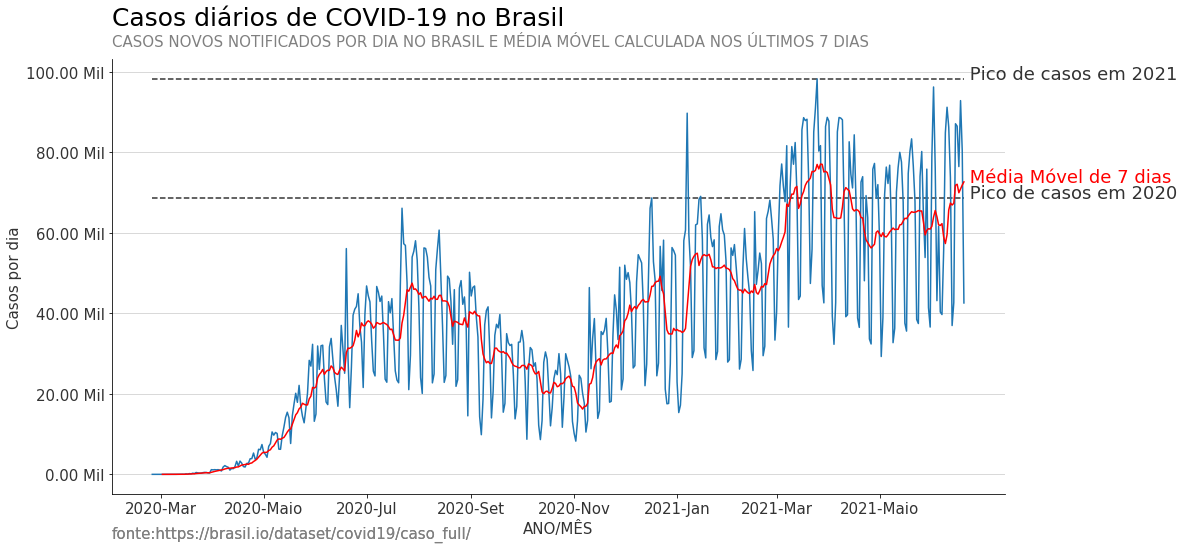

In [37]:
ax_casos=plot_time_series(dados_br[['casos_novos', 'date']])
plot_time_series(dados_br[['MM7_casos', 'date']],'Casos diários de COVID-19 no Brasil', 
                 'CASOS NOVOS NOTIFICADOS POR DIA NO BRASIL E MÉDIA MÓVEL CALCULADA NOS ÚLTIMOS 7 DIAS', color='red', ax=ax_casos, 
                 xlabel='ANO/MÊS', ylabel='Casos por dia', formatter_y=thousand_formatter)
plt.hlines(max(dados_br[dados_br['date'].dt.year == 2020].dropna()['casos_novos']), min(dados_br['date']), max(dados_br['date']), linestyle='--', alpha=0.8)
plt.annotate(' Pico de casos em 2020', (dados_br['date'].iloc[-1],max(dados_br[dados_br['date'].dt.year == 2020].dropna()['casos_novos'])), color='black', alpha=0.8)
plt.annotate(' Média Móvel de 7 dias', (dados_br['date'].iloc[-1],dados_br['MM7_casos'].iloc[-1]), color='red')
plt.hlines(max(dados_br.dropna()['casos_novos']), min(dados_br['date']), max(dados_br['date']), linestyle='--', alpha=0.8)
plt.annotate(' Pico de casos em 2021', (dados_br['date'].iloc[-1],max(dados_br.dropna()['casos_novos'])), color='black', alpha=0.8)
plt.show()

Analisando os dados diários de casos novos de COVID-19 no Brasil inteiro, em um primeiro momento podemos notar que há uma tendência de subida em 2021 em relação a 2020, esse fato é reforçado se observamos os picos de 2020 e de 2021, em que a média móvel de 7 dias, em 2021, conseguiu ultrapassar o  pico de casos de 2020

Além disso parece haver um "sobe e desce" no gráfico, onde parece haver um padrão nos dias de picos e logo após uma queda, um fato que pode explicar esse comportamento pode ser a sazonalidade semanal, em que, provavelmente algum dias das semanas costumam haver mais casos notificados do que outros dias.

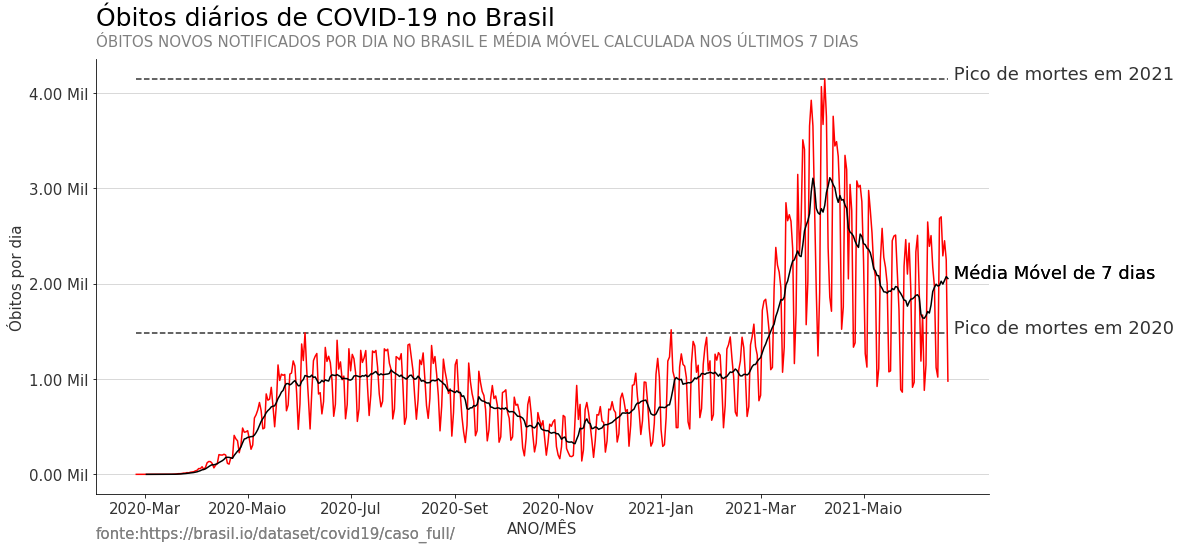

In [38]:
ax_obitos=plot_time_series(dados_br[['obitos_novos', 'date']], color='red')
plot_time_series(dados_br[['MM7_obitos', 'date']],'Óbitos diários de COVID-19 no Brasil',
                 'ÓBITOS NOVOS NOTIFICADOS POR DIA NO BRASIL E MÉDIA MÓVEL CALCULADA NOS ÚLTIMOS 7 DIAS', color='black', ax=ax_obitos, 
                 xlabel='ANO/MÊS', ylabel='Óbitos por dia',formatter_y=thousand_formatter)
plt.hlines(max(dados_br[dados_br['date'].dt.year == 2020]['obitos_novos']), min(dados_br['date']), max(dados_br['date']), linestyle='--', alpha=0.8)
plt.annotate(' Pico de mortes em 2020', (dados_br['date'].iloc[-1],max(dados_br[dados_br['date'].dt.year == 2020]['obitos_novos'])), color='black', alpha=0.8)
plt.hlines(max(dados_br.dropna()['obitos_novos']), min(dados_br['date']), max(dados_br['date']), linestyle='--', alpha=0.8)
plt.annotate(' Pico de mortes em 2021', (dados_br['date'].iloc[-1],max(dados_br.dropna()['obitos_novos'])), color='black', alpha=0.8)
plt.annotate(' Média Móvel de 7 dias', (dados_br['date'].iloc[-1],dados_br['MM7_obitos'].iloc[-1]), color='black')
plt.annotate(' Média Móvel de 7 dias', (dados_br['date'].iloc[-1],dados_br['MM7_obitos'].iloc[-1]), color='black')
plt.show()

Dessa vez observando o gráfico de óbitos diários por dia fica evidente que as mortes em 2021 aumentaram em relação ao ano de 2020. O pico de mortes em um dia em 2021 superou muito o pico de 2020, e além disso a média móvel, em 2021, ficou um período grande acima do pico de 2020, fato que reforça esse aumento observado nos óbitos por COVID-19 no Brasil

Para ver se o aumento de mortes aumentou na mesma proporção que os números de casos vamos observar a razão entre óbitos e casos somados a cada mês.

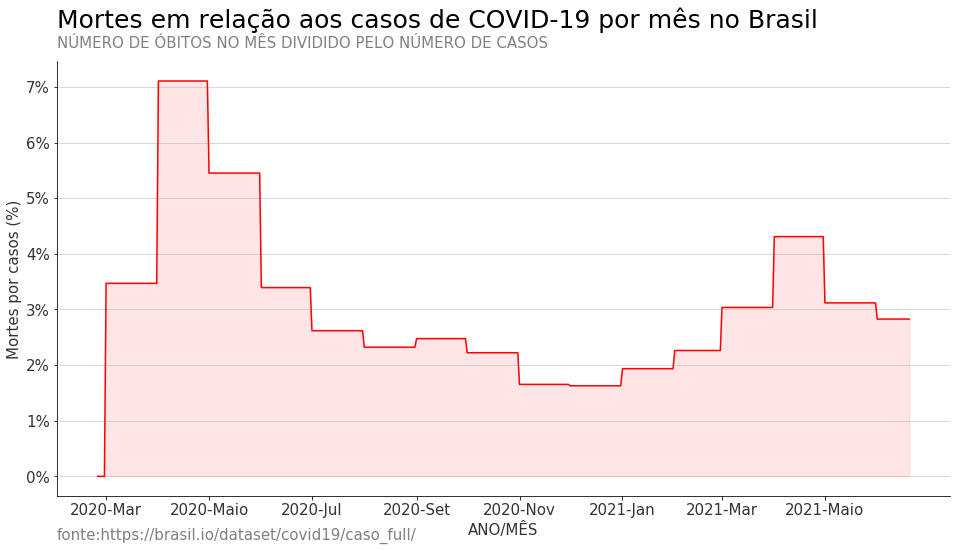

In [39]:
plot_time_series(dados_br[['letalidade_mes', 'date']],'Mortes em relação aos casos de COVID-19 por mês no Brasil', 'NÚMERO DE ÓBITOS NO MÊS DIVIDIDO PELO NÚMERO DE CASOS', 
                 xlabel='ANO/MÊS', ylabel='Mortes por casos (%)',formatter_y=percent_formatter, color='red')
plt.fill_between(dados_br['date'], dados_br['letalidade_mes'], color='red', alpha=0.1)
plt.show()

A partir do gráfico acima percebe se que houve um aumento muito grande no começo da pandemia, provavelmente, pelo fato de tudo ser novo e desconhecido, após isso notamos uma queda nessa razão mensal até o final de 2020. No entanto, 2021 parece ter começado com uma piora mês após mês, indicando que a letalidade do vírus pode ter aumentado em 2021 em relação ao final de 2020.

Para tentar achar alguma relação entre os dados de casos e óbitos ao longo dos dias podemos olhar uma correlação cruzada das duas variáveis. Para isso vou calcular a correlação entre os dados de óbitos com os dados de casos nos dias anteriores para descobrir quantos dias anteriores o número de casos influencia o de óbitos no dia.

O método utilizado será a correlação de Spearman que leva em consideração a relação das duas variáveis a partir da posição em um rank dessas variáveis em cada observação.

In [40]:
df_corr = pd.DataFrame()
dias_antes = []
corr = []

for i in range(1,22):
    dias_antes.append(i)
    corr.append(dados_br['obitos_novos'].corr(dados_br['casos_novos'].shift(i), method='spearman'))
df_corr['Casos_XDias_antes'] = dias_antes
df_corr['Correlacao_obitos'] = corr
df_corr = df_corr.set_index('Casos_XDias_antes')
df_corr

,Correlacao_obitos
Casos_XDias_antes,
1,0.762410
2,0.617477
3,0.562434
4,0.576296
5,0.638316
6,0.780225
7,0.860328
8,0.738217
9,0.602470


A partir da tabela percebemos que as maiores correlações são 7,14 e 21 dias, isso quer dizer que os dados de óbitos tem uma correlação alta com os dados de casos do mesmo dia da semana de semanas anteriores o que já é um indicativo de haver uma sazonalidade semelhante na notificação de casos e de óbitos.

# 8 - Modelos de previsões

## 8.1 - Tipo de modelo

A fim de encontrar os padrões temporais será utilizado o pacote [fbprophet](), esse pacote possui um forecaster com um foco específico para séries temporais, primeiramente vamos partir do pressuposto que existe uma sazonalidade semanal na notificação de casos e óbitos por COVID-19, e a partir dessa hipótese analisar as previsões do Prophet para descobrir se há fatores que corroboram com essa hipótese ou não.

## 8.2 - Métricas escolhidas

As métricas escolhidas para se analisar a performance do modelo e escolher os melhores parâmetros serão a MAE(erro médio absoluto) e a RMSE(raíz do erro médio ao quadrado), eu escolhi essas duas métricas pois acredito que são mais claras para interpretação uma vez que a unidade delas é a mesma que a variável analisada. Além disso, a RMSE é mais sensível aos erros maiores, enquanto a MAE não, ou seja, analisar a diferença entre as duas métricas pode ajudar a perceber se existe um impacto grande ou não dos outliers(valores extremos que podem gerar erros mais altos), portanto o nosso objetivo será otimizar os parâmetros primeiramente a fim de baixar a média das duas métricas e depois disso tentar retirar outliers a fim de diminuir a diferença das duas métricas.

__Cross Validation__

As métricas serão calculadas a partir da técnica de cross_validation que, no caso de séries temporais, pega um início temporal e um intervalo e a partir desse início treina os dados anteriores e teste os próximos dados correspondentes a esse intervalo pré-definido('horizon'), e vai fazendo esse processo até chegar o final da série temporal.

## 8.3 - Modelo para prever casos por dia de COVID-19 no Brasil

### 8.3.1 - Problema a ser resolvido

O primeiro modelo terá como foco prever os casos novos de COVID-19 no Brasil por dia nos próximos 30 dias.

### 8.3.2 - Modelo mais simples

A fim de ter um ponto de partida como referência para realizar as melhoras do modelo será criado o modelo mais simples possível pelo Prophet a partir dos dados de casos novos por dia de COVID-19 no Brasil.

In [41]:
dados_casos = dados_br[['date', 'casos_novos']]
dados_casos.columns = ['ds', 'y']

In [42]:
modelo_casos_simples = Modelo_prophet_semanal(dados_casos)
modelo_casos_simples.c_valid(initial='180 days', period='30 days', horizon='30 days')
modelo_casos_simples.metricas()
modelo_casos_simples.metricas

  0%|          | 0/10 [00:00<?, ?it/s]

,horizon,rmse,mae,media_metricas,diff_rmse_mae
0,3 days,13368.197327,11038.517999,12203.357663,2329.679328
1,4 days,13679.54096,11991.16945,12835.355205,1688.37151
2,5 days,13844.469859,11885.922064,12865.195962,1958.547795
3,6 days,13720.231101,10898.107956,12309.169528,2822.123145
4,7 days,13100.647384,9930.465632,11515.556508,3170.181753
5,8 days,12252.438962,9404.732604,10828.585783,2847.706358
6,9 days,11495.324568,9210.813893,10353.06923,2284.510675
7,10 days,12926.699693,10629.552158,11778.125926,2297.147535
8,11 days,15476.391253,12772.2598,14124.325527,2704.131453
9,12 days,16538.252721,13895.409158,15216.83094,2642.843563


Nota se que a média das médias das duas métricas definidas durante todo o intervalo de tempo foi de aproximadamente 15202, ou seja, esse é o ponto de partida que iremos tentar melhorar esse erro.

### 8.3.3 - Modelo com 'seasonality_mode' igual a 'multiplicative'

O parâmetro 'seasonality_mode' define como a sazonalidade se comporta ao longo do tempo, se é de uma maneira aditiva, ou seja, as mudanças ocorrem com uma taxa constante, ou multiplicativa, em que a taxa de mudanças é proporcional aos valores dos dados.

In [43]:
modelo_casos_1 = Modelo_prophet_semanal(dados_casos, seasonality_mode='multiplicative')
modelo_casos_1.c_valid(initial='180 days', period='30 days', horizon='30 days')
modelo_casos_1.metricas()
modelo_casos_1.metricas

  0%|          | 0/10 [00:00<?, ?it/s]

,horizon,rmse,mae,media_metricas,diff_rmse_mae
0,3 days,12749.758486,8896.354932,10823.056709,3853.403554
1,4 days,11851.506053,9082.020352,10466.763202,2769.4857
2,5 days,12079.984733,9401.064468,10740.5246,2678.920265
3,6 days,12150.072921,9115.197787,10632.635354,3034.875134
4,7 days,12662.945952,9178.103187,10920.524569,3484.842766
5,8 days,12891.528361,9106.558811,10999.043586,3784.969551
6,9 days,11891.317784,8254.972848,10073.145316,3636.344936
7,10 days,12460.844537,8739.737693,10600.291115,3721.106844
8,11 days,14462.157213,10676.766159,12569.461686,3785.391054
9,12 days,15204.098077,12082.087419,13643.092748,3122.010658


Podemos ver que mudando o modo da sazonalidade para multiplicativo em vez de aditivo tivemos uma melhora nessa média das médias das duas métricas, atingindo um valor de aproximadamente 13423.

### 8.3.4 - otimização do parâmetro 'changepoint_prior_scale'

O parâmetro 'changepoint_prior_scale' define como o modelo olha para as mudanças ao longo do tempo, quanto maior esse parâmetro maior será a flexibilização das mudanças de tendências ao longo do tempo. Para tentar achar o melhor valor para esse parâmetro serão testados todos os valores inteiros entre 1 e 10 e a média das métricas MAE e RMSE será o que vai decidir o melhor valor para o parâmetro. 

In [44]:
for changepoint_prior in range(1,11,1):
    modelo = Modelo_prophet_semanal(dados_casos, changepoint_prior_scale=changepoint_prior, seasonality_mode='multiplicative')
    modelo.c_valid(initial='180 days', period='30 days', horizon='30 days')
    modelo.metricas()
    print(f'changepoint_prior_scale igual a {changepoint_prior}')
    print(modelo.metricas.loc['media', 'media_metricas'])

  0%|          | 0/10 [00:00<?, ?it/s]

changepoint_prior_scale igual a 1
12905.512973840321


  0%|          | 0/10 [00:00<?, ?it/s]

changepoint_prior_scale igual a 2
12844.765597958267


  0%|          | 0/10 [00:00<?, ?it/s]

changepoint_prior_scale igual a 3
12775.222458300428


  0%|          | 0/10 [00:00<?, ?it/s]

changepoint_prior_scale igual a 4
12751.67858857319


  0%|          | 0/10 [00:00<?, ?it/s]

changepoint_prior_scale igual a 5
12733.080270870432


  0%|          | 0/10 [00:00<?, ?it/s]

changepoint_prior_scale igual a 6
12705.89762072686


  0%|          | 0/10 [00:00<?, ?it/s]

changepoint_prior_scale igual a 7
12690.129130171947


  0%|          | 0/10 [00:00<?, ?it/s]

changepoint_prior_scale igual a 8
12674.890394028256


  0%|          | 0/10 [00:00<?, ?it/s]

changepoint_prior_scale igual a 9
12656.10003427921


  0%|          | 0/10 [00:00<?, ?it/s]

changepoint_prior_scale igual a 10
12655.683209556175


Podemos notar que o parâmetro 'changepoint_prior_scale' igual a 10 obteve o melhor resultado dentre os valores testados, isso indica que se colocamos uma prioridade maior para as mudanças de tendência temos uma melhor performance, por esta razão utilizarei esse valor a partir de agora.

### 8.3.5 - Outliers

Agora com o objetivo de melhorar o modelo, vamos olhar para os outliers, para definir um valor com outliers vamos usar o próprio modelo do Prophet, uma vez que o modelo gera um intervalo de confiança de 95% desses valores, ou seja, os valores fora desse intervalo será considerado um outlier.

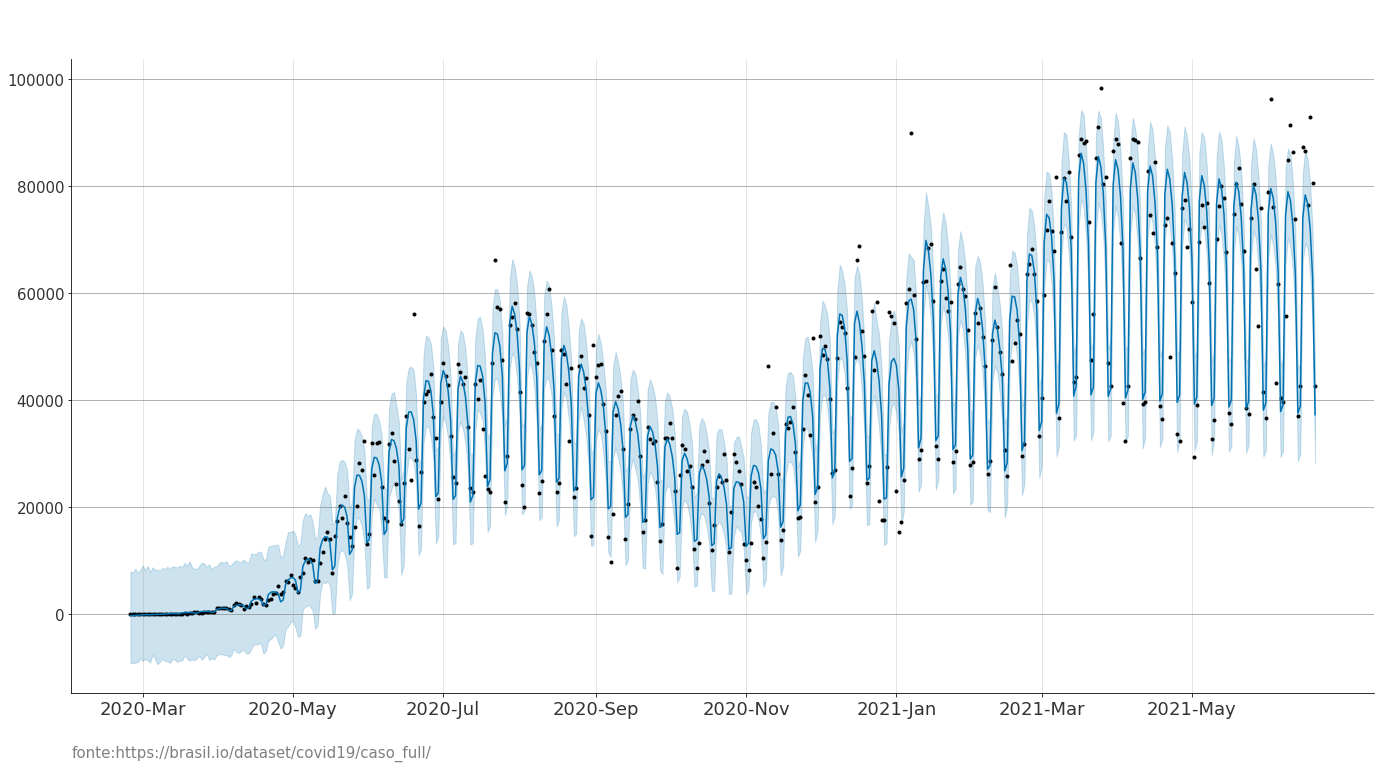

In [45]:
modelo_otimizado = Modelo_prophet_semanal(dados_casos, changepoint_prior_scale=10.0, seasonality_mode='multiplicative')
modelo_otimizado.plota()

A partir do gráfico podemos observar o intervalo de confiança onde há uma sombra azul, e nota se alguns dados que estão fora desse intervalo, e, como uma forma de melhorar a performance irei eliminar esses dados.

In [46]:
modelo_otimizado.previsao.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2020-02-25,-212.763526,-9113.186025,8014.251189,-212.763526,-212.763526,0.173783,0.173783,0.173783,0.173783,0.173783,0.173783,0.0,0.0,0.0,-249.738124
1,2020-02-26,-192.895427,-9088.687110,7778.132768,-192.895427,-192.895427,0.245263,0.245263,0.245263,0.245263,0.245263,0.245263,0.0,0.0,0.0,-240.205502
2,2020-02-27,-173.027329,-9032.277185,8560.302091,-173.027329,-173.027329,0.219246,0.219246,0.219246,0.219246,0.219246,0.219246,0.0,0.0,0.0,-210.962795
3,2020-02-28,-153.159230,-8923.714272,7750.428645,-153.159230,-153.159230,0.147398,0.147398,0.147398,0.147398,0.147398,0.147398,0.0,0.0,0.0,-175.734624
4,2020-02-29,-133.291132,-8219.946289,8266.031739,-133.291132,-133.291132,0.002631,0.002631,0.002631,0.002631,0.002631,0.002631,0.0,0.0,0.0,-133.641833


In [47]:
dados_casos = modelo_otimizado.previsao[['ds', 'yhat_upper', 'yhat_lower']].merge(dados_casos)
dados_sem_outliers = dados_casos[(dados_casos['y'] > dados_casos['yhat_lower']) & (dados_casos['y'] < dados_casos['yhat_upper'])]
dados_sem_outliers = dados_sem_outliers.drop(columns=['yhat_upper', 'yhat_lower'])

In [48]:
modelo_sem_out = Modelo_prophet_semanal(dados_sem_outliers, changepoint_prior_scale=10.0, seasonality_mode='multiplicative')
modelo_sem_out.c_valid(initial='180 days', period='30 days', horizon='30 days')
modelo_sem_out.metricas()
modelo_sem_out.metricas

  0%|          | 0/10 [00:00<?, ?it/s]

,horizon,rmse,mae,media_metricas,diff_rmse_mae
0,3 days,7569.206213,5644.461643,6606.833928,1924.74457
1,4 days,7608.114815,5876.484558,6742.299686,1731.630256
2,5 days,7187.516503,6134.813493,6661.164998,1052.703009
3,6 days,6923.426099,5988.467705,6455.946902,934.958395
4,7 days,7669.065401,6318.57038,6993.817891,1350.495021
5,8 days,7985.580533,6712.997472,7349.289003,1272.583061
6,9 days,9322.233479,7481.273553,8401.753516,1840.959926
7,10 days,9797.31505,7738.625488,8767.970269,2058.689563
8,11 days,10708.692391,8546.065101,9627.378746,2162.62729
9,12 days,11249.666944,9479.332931,10364.499938,1770.334013


Agora a partir da eliminação dos dados outliers obtivemos uma média das métricas de 11061, saindo de um valor de 15202, e a diferença das duas métricas diminui de 2828 para 2166, indicando que os erros extremos diminuiram.

### 8.3.6 - Visualização do modelo

Por fim vamos visualizar os dados previstos pelo modelo em um gráfico, para isso vamos usar os parâmetros obtidos para criar um modelo para ser testados com os últimos 30 dias, e os demais destinados para teste.

In [ ]:
modelo_final= Modelo_prophet_semanal(dados_sem_outliers, changepoint_prior_scale=10.0, 
                                     teste_periodo=30, seasonality_mode='multiplicative')
modelo_final.plota('Previsão dos dados de casos novos Prophet', 'VISUALIZAÇÃO DA PREVISÃO DOS CASOS NOVOS DE COVID-19 NO BRASIL', xlabel='DATA', ylabel='CASOS NOVOS')
plt.show()

A partir do gráfico acima nota se que modelo conseguiu se adequar muito bem aos dados, e para tentar entender a sazonalidade encontrada vamos observar os componentes gerados pelo Prophet.

In [ ]:
modelo_final.modelo.plot_components(modelo_final.previsao, figsize=(20,10));

Podemos ver que no gráfico de dia por semana nota se que o Domingo e a Segunda tem uma diminuição muito grande nos casos registrados, enquanto no resto da semana esses números tem uma tendência a aumentar, o que corrobora com a hipótese de haver uma sazonalidade semanal na notificação de casos.

In [ ]:
!pip freeze > requirements.txt #comando utilizado para gerar o arquivo requirements.txt

# Conclusões

A partir das análises dos dados foi possível concluir:

* Em 2021, a média móvel de óbitos conseguiu superar o pico de mortes de 2020 em diversos momentos
* Em 2021, a média móvel de casos novos também conseguiu superar o pico de casos novos de 2020
* Existe uma sazonalidade semanal na notificação dos casos, em que no Domingo e na Segunda esses números costumam cair
* Existe uma correlação entre os óbitos e os casos nos dias anteriores, principalmente nos mesmos dias da semana uma semana antes